In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import tts
import tts.utils

# Rerun this cell to load changes in the ttf module
import importlib
importlib.reload(tts)
importlib.reload(tts.utils)

# Total ligands for test. Since we will try many parameters, set it very low. Otherwise it will take forever.
TOTAL_TEST_LIGANDS = 2

In [3]:
# Load the ligand dataset
data_supplier = Chem.SDMolSupplier('glass.sdf')
ligands = []
for i, ligand in enumerate(data_supplier):
    if i > TOTAL_TEST_LIGANDS:
        break
    ligands.append(ligand)

In [4]:
# Let's remove ligands with rare Br and P atoms
filtered_ligands = []
for ligand in ligands:
    good = True
    for atom in ligand.GetAtoms():
        if atom.GetSymbol() in ['Br', 'P']:
            good = False
            break
    if good:
        filtered_ligands.append(ligand)
ligands = filtered_ligands

In [5]:
# Create conformers
conformers = []

for i, ligand in enumerate(ligands):
    if i % 50 == 0:
        print(i)
    try:
        conformer = Chem.AddHs(ligand)
        Chem.AllChem.EmbedMolecule(conformer)
        Chem.AllChem.UFFOptimizeMolecule(conformer)
        conformer = Chem.RemoveHs(conformer)
        conformers.append(conformer)
    except Exception as error:
        print(str(i) + ': ' + str(error))

0


In [6]:
descriptors = {
    6: tts.AtomDescriptor(1.0, {0, 1}),  # C
    7: tts.AtomDescriptor(0.9, {0, 2}),  # N
    8: tts.AtomDescriptor(0.85, {0, 3}),  # O
    9: tts.AtomDescriptor(0.8, {0, 4}),  # F
    16: tts.AtomDescriptor(1.0, {0, 5}),  # S
    17: tts.AtomDescriptor(0.9, {0, 6}),  # Cl
}

maximal_valence = {
    6: 4,
    7: 3,
    8: 2,
    9: 1,
    16: 6,
    17: 1,
}

def test_get_distances(lhs, rhs):
    # https://www.chegg.com/homework-help/using-bond-lengths-table-92-p-340-assuming-ideal-geometry-ca-chapter-10-problem-95p-solution-9780077340230-exc
    pair = set([lhs, rhs])

    if pair == set([6, 6]):  # C C
        return [1.27, 1.44, 1.64]
    elif pair == set([6, 7]):  # C N
        return [1.21, 1.37, 1.65]
    elif pair == set([6, 8]):  # C O
        return [1.18, 1.33, 1.53]
    elif pair == set([6, 9]):  # C F
        return [0, 0, 1.43]
    elif pair == set([6, 16]):  # C S
        return [0, 0, 1.91]
    elif pair == set([6, 17]):  # C Cl
        return [0, 0, 1.88]
    elif pair == set([7, 7]):  # N N
        return [1.16, 1.34, 1.56]
    elif pair == set([7, 8]):  # N O
        return [1.13, 1.32, 1.52]
    elif pair == set([7, 9]):  # N F
        return [0, 0, 1.49]
    elif pair == set([7, 16]):  # N S
        return [0, 0, 0]
    elif pair == set([7, 17]):  # N Cl
        return [0, 0, 2.0]
    elif pair == set([8, 8]):  # O O
        return [0, 1.34, 1.58]
    elif pair == set([8, 9]):  # O F
        return [0, 0, 1.52]
    elif pair == set([8, 16]):  # O S
        return [0, 0, 1.61]
    elif pair == set([8, 17]):  # O Cl
        return [0, 0, 1.74]
    elif pair == set([9, 9]):  # F F
        return [0, 0, 1.53]
    elif pair == set([9, 16]):  # F S
        return [0, 0, 1.68]
    elif pair == set([9, 17]):  # F Cl
        return [0, 0, 1.76]
    elif pair == set([16, 16]):  # S S
        return [0, 0, 2.14]
    elif pair == set([16, 17]):  # S Cl
        return [0, 0, 2.11]
    elif pair == set([17, 17]):  # Cl Cl
        return [0, 0, 2.09]
    else:
        raise RuntimeError('Unknown distances for pair ' + str(pair))

In [7]:
# Generate conformers
original_tensors = []
for conformer in conformers:
    molecule = tts.rdkit_to_molecule(conformer)
    tensor = tts.utils.test_voxelizer(molecule, descriptors)
    original_tensors.append(tensor)

In [11]:
# Let's compare time and rms for different tolerance settings
import time

times = []
rms = []
tanimoto = []
molecules = []

tolerances = [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for tol in tolerances:
    print('Tolerance', tol)
    
    tol_times = []
    tol_rms = []
    tol_tanimoto = []
    tol_molecules = []
    
    for i, original_tensor in enumerate(original_tensors):
        print('Tensor', i)
        num_atoms = len(tts.rdkit_to_molecule(conformers[i]))

        start = time.time()
        results = tts.tensor_to_structure(original_tensor,
                                          descriptors,
                                          voxel_step=0.5,
                                          min_atoms=num_atoms,
                                          max_atoms=num_atoms+1,
                                          trials=100,
                                          max_iter=500,
                                          n_init=10,
                                          tol=tol,
                                          threshold=0.1)
        stop = time.time()
        tol_times.append(stop - start)
        
        result = results[0][0]
        if result is None:
            rol_rms.append(None)
            tol_tanimoto.append(None)
            tol_molecules.append(None)
            continue
            
        result_molecule = tts.get_bonds(result, test_get_distances, maximal_valence)
        tol_molecules.append(result_molecule)
        
        try:
            cur_rms = tts.get_best_rms(result_molecule, conformers[i])
        except:
            cur_rms = None
        tol_rms.append(cur_rms)
        
        tol_tanimoto.append(tts.get_ecfp_similarity(result_molecule, conformers[i]))
    
    times.append(tol_times)
    rms.append(tol_rms)
    tanimoto.append(tol_tanimoto)
    molecules.append(tol_molecules)
    print()

Tolerance 1.0
Tensor 0
Tensor 1
Tensor 2

Tolerance 0.1
Tensor 0
Tensor 1
Tensor 2

Tolerance 0.01
Tensor 0
Tensor 1
Tensor 2

Tolerance 0.001
Tensor 0
Tensor 1
Tensor 2

Tolerance 0.0001
Tensor 0
Tensor 1
Tensor 2

Tolerance 1e-05
Tensor 0
Tensor 1
Tensor 2

Tolerance 1e-06
Tensor 0
Tensor 1
Tensor 2



In [12]:
rms

[[None, 1.985976838706664, 2.1527074169132314],
 [1.668983097386365, 2.3339346830716163, None],
 [None, 2.566791113222235, None],
 [0.3801230667378935, 0.28872528829855904, 2.923911676116163],
 [None, None, None],
 [None, None, 0.09915375399180079],
 [0.11813799963069663, 0.08346870039817728, None]]

In [15]:
np_times = np.array(times)

Text(0, 0.5, 'Time in seconds')

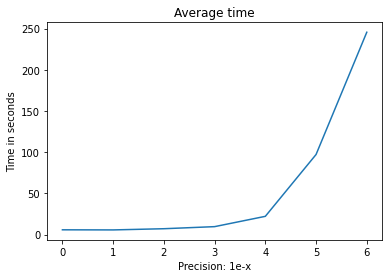

In [26]:
plt.plot(range(0, 7),np_times.mean(axis=1))
plt.title('Average time')
plt.xlabel('Precision: 1e-x')
plt.ylabel('Time in seconds')

In [45]:
# Let's compare different n_init
import time

times = []
rms = []
tanimoto = []
molecules = []

n_inits = [1, 10, 20, 50]
for n_init in n_inits:
    print('n_init', n_init)
    
    tol_times = []
    tol_rms = []
    tol_tanimoto = []
    tol_molecules = []
    
    for i, original_tensor in enumerate(original_tensors):
        print('Tensor', i)
        num_atoms = len(tts.rdkit_to_molecule(conformers[i]))

        start = time.time()
        results = tts.tensor_to_structure(original_tensor,
                                          descriptors,
                                          voxel_step=0.5,
                                          min_atoms=num_atoms,
                                          max_atoms=num_atoms+1,
                                          trials=100,
                                          max_iter=500,
                                          n_init=n_init,
                                          tol=0.001,
                                          threshold=0.1)
        stop = time.time()
        tol_times.append(stop - start)
        
        result = results[0][0]
        if result is None:
            rol_rms.append(None)
            tol_tanimoto.append(None)
            tol_molecules.append(None)
            continue
        result_molecule = tts.get_bonds(result, test_get_distances, maximal_valence)
        tol_molecules.append(result)
        
        try:
            cur_rms = tts.get_best_rms(tts.molecule_to_rdkit(result_molecule), conformers[i])
        except:
            cur_rms = None
        tol_rms.append(cur_rms)
        tol_tanimoto.append(tts.get_ecfp_similarity(result_molecule, conformers[i]))
    
    times.append(tol_times)
    rms.append(tol_rms)
    tanimoto.append(tol_tanimoto)
    molecules.append(tol_molecules)
    print()

n_init 1
Tensor 0
Tensor 1
Tensor 2

n_init 10
Tensor 0
Tensor 1
Tensor 2

n_init 20
Tensor 0
Tensor 1
Tensor 2

n_init 50
Tensor 0
Tensor 1
Tensor 2



In [46]:
rms

[[None, None, None],
 [None, None, None],
 [None, None, None],
 [None, None, None]]

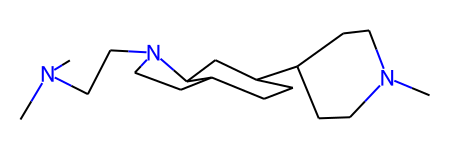

In [47]:
result = molecules[-1][2]
tts.get_bonds(result, test_get_distances, maximal_valence)

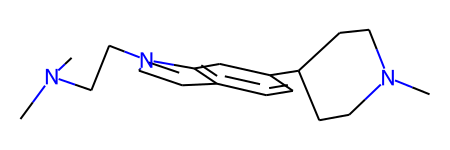

In [48]:
conformers[2]

<IPython.core.display.Javascript object>


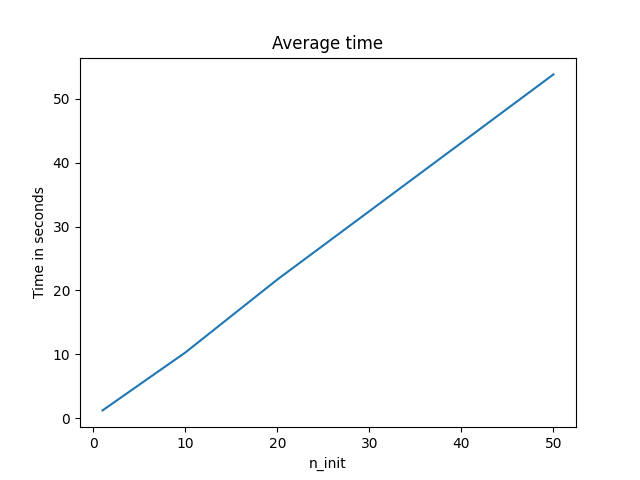

In [55]:
np_times = np.array(times)
plt.figure()
plt.plot([1, 10, 20, 50],np_times.mean(axis=1))
plt.title('Average time')
plt.xlabel('n_init')
plt.ylabel('Time in seconds')
plt.show()

In [59]:
# Let's compare different trial
import time

times = []
rms = []
tanimoto = []
molecules = []

trials = [50, 100, 150, 200]
for trial in trials:
    print('trial', trial)
    
    tol_times = []
    tol_rms = []
    tol_tanimoto = []
    tol_molecules = []
    
    for i, original_tensor in enumerate(original_tensors):
        print('Tensor', i)
        num_atoms = len(tts.rdkit_to_molecule(conformers[i]))

        start = time.time()
        results = tts.tensor_to_structure(original_tensor,
                                          descriptors,
                                          voxel_step=0.5,
                                          min_atoms=num_atoms,
                                          max_atoms=num_atoms+1,
                                          trials=trial,
                                          max_iter=500,
                                          n_init=3,
                                          tol=0.0001,
                                          threshold=0.1)
        stop = time.time()
        tol_times.append(stop - start)
        
        result = results[0][0]
        if result is None:
            rol_rms.append(None)
            tol_tanimoto.append(None)
            tol_molecules.append(None)
            continue
        result_molecule = tts.get_bonds(result, test_get_distances, maximal_valence)
        tol_molecules.append(result)
        
        try:
            cur_rms = tts.get_best_rms(tts.molecule_to_rdkit(result_molecule), conformers[i])
        except:
            cur_rms = None
        tol_rms.append(cur_rms)
        tol_tanimoto.append(tts.get_ecfp_similarity(result_molecule, conformers[i]))
    
    times.append(tol_times)
    rms.append(tol_rms)
    tanimoto.append(tol_tanimoto)
    molecules.append(tol_molecules)
    print()

trial 50
Tensor 0
Tensor 1
Tensor 2

trial 100
Tensor 0
Tensor 1
Tensor 2

trial 150
Tensor 0
Tensor 1
Tensor 2

trial 200
Tensor 0
Tensor 1
Tensor 2



In [60]:
rms

[[None, None, None],
 [None, None, None],
 [None, None, None],
 [None, None, None]]

In [61]:
mol2 = tts.get_bonds(molecules[-1][2], test_get_distances, maximal_valence)

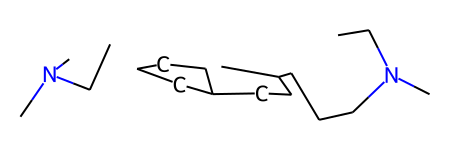

In [62]:
mol2

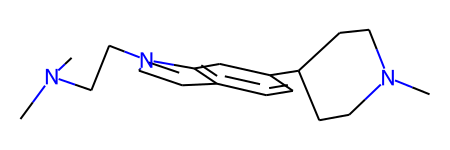

In [63]:
conformers[2]

<IPython.core.display.Javascript object>


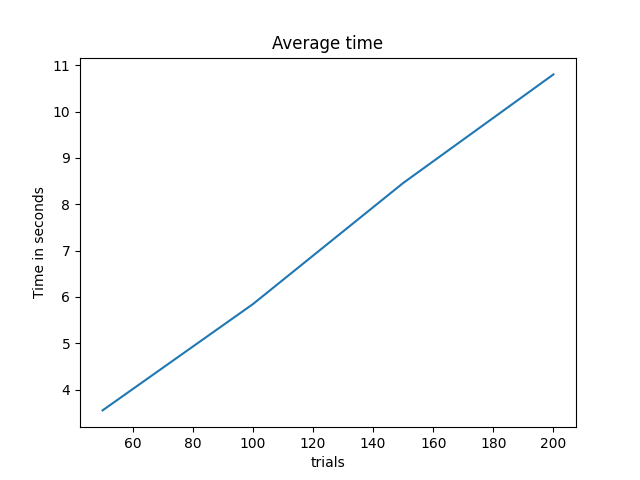

In [64]:
np_times = np.array(times)
plt.figure()
plt.plot([50, 100, 150, 200],np_times.mean(axis=1))
plt.title('Average time')
plt.xlabel('trials')
plt.ylabel('Time in seconds')
plt.show()

# Conclusion

The main problem is bond estimation. I use known bond length I found in the Internet, but it is too different with the glass dataset. Fast parameters can estimate atom coordinates good enough (You can see it by your eyes at tts.utils.plot_coordinates()), but wrong bonds prevents metric evaluation. 

The time is linear with respect to trials and n_init, and somewhat exponential to log precision.